In [144]:
import pandas as pd
import altair as alt
import json
import geopandas as gpd
import basedosdados as bd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns



In [145]:
# Para carregar o dado direto no pandas
detalhes_votacao_municipio = bd.read_table(dataset_id='br_tse_eleicoes',
                    table_id='detalhes_votacao_municipio',
                    billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 320628/320628 [01:52<00:00, 2849.28rows/s]


In [182]:
# get rows where cargo is "PRESIDENTE" and id_municipio is not null
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)

# get only id_municipio, sigla_uf, votos_validos, votos_brancos, votos_nulos, proporcao_votos_brancos, proporcao_votos_nulos
election_2018 = election_2018[['id_municipio', 'sigla_uf', 'votos_validos', 'votos_brancos', 'votos_nulos', 'proporcao_votos_brancos', 'proporcao_votos_nulos', 'turno']]
election_2018

,id_municipio,sigla_uf,votos_validos,votos_brancos,votos_nulos,proporcao_votos_brancos,proporcao_votos_nulos,turno
60795,1100015,RO,12691,228,516,1.697060,3.840714,1
60800,1100023,RO,48048,850,1797,1.676694,3.544728,1
60805,1100031,RO,3406,61,148,1.687414,4.094053,1
60810,1100049,RO,47345,860,1695,1.723447,3.396794,1
60815,1100056,RO,9658,126,338,1.244813,3.339261,1
...,...,...,...,...,...,...,...,...
315780,2933307,BA,173514,3071,14860,1.604116,7.762021,2
315781,2933406,BA,4542,38,241,0.788218,4.998963,2
315782,2933455,BA,7058,55,238,0.748197,3.237655,2
315783,2933505,BA,10627,133,635,1.167179,5.572619,2


In [91]:
municipio_geometry = bd.read_table(dataset_id='br_geobr_mapas',
                table_id='municipio',
                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 5567/5567 [01:19<00:00, 69.81rows/s]


In [183]:
# get municipio where state is RJ
municipio_geometry_rj = municipio_geometry.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")
#municipio_geometry_rj = municipio_geometry
municipio_geometry_rj = pd.merge(municipio_geometry_rj, election_2018, on='id_municipio', how = 'inner')
municipio_geometry_rj = municipio_geometry_rj[['id_municipio', 'sigla_uf_x', 'votos_validos', 'votos_brancos', 'votos_nulos', 'proporcao_votos_brancos', 'proporcao_votos_nulos', 'geometria', 'turno']]


In [184]:
municipio_geometry_rj['geometria'] = municipio_geometry_rj['geometria'].apply(wkt.loads)
municipio_geometry_rj_gpd = gpd.GeoDataFrame(municipio_geometry_rj, geometry='geometria')
municipio_geometry_rj_gpd['proporcao_brancos_nulos'] = municipio_geometry_rj_gpd['proporcao_votos_brancos'] + municipio_geometry_rj_gpd['proporcao_votos_nulos']


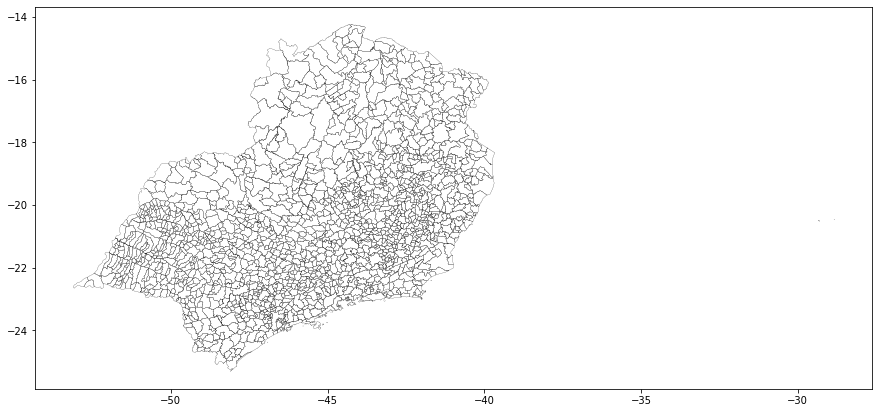

In [185]:
ax = municipio_geometry_rj_gpd.boundary.plot(figsize = (15, 15), edgecolor = 'black', linewidth = 0.1)

In [152]:
flt1 = ((municipio_geometry_rj_gpd['turno'] == 1))
flt2 = ((municipio_geometry_rj_gpd['turno'] == 2))


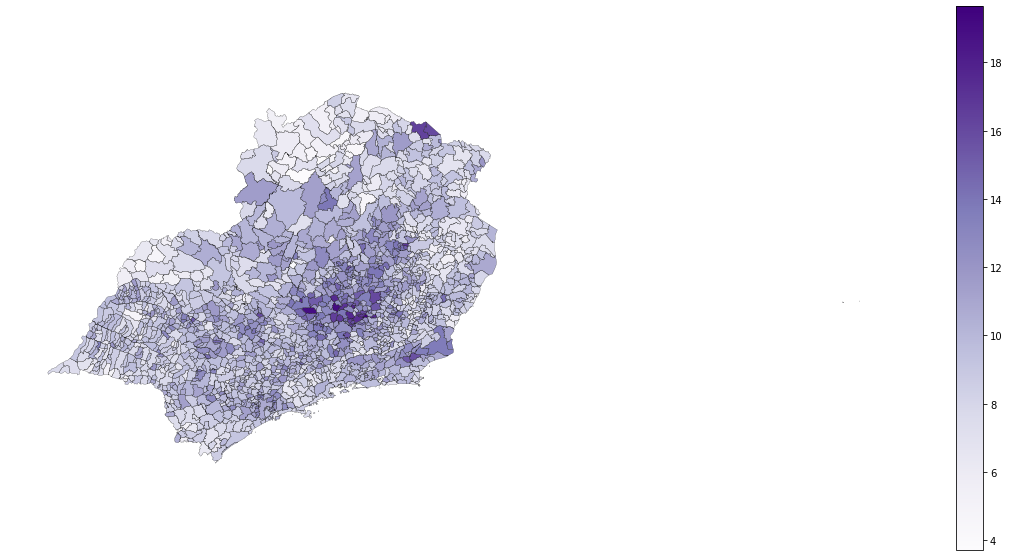

In [187]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_rj_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_rj_gpd[flt1].plot(column = 'proporcao_brancos_nulos',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples'
                                        )
ax.set_axis_off()
plt.show()